In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

(512, 512, 512)


Text(0.5, 1.0, 'Lagrangian Density pre re-ion')

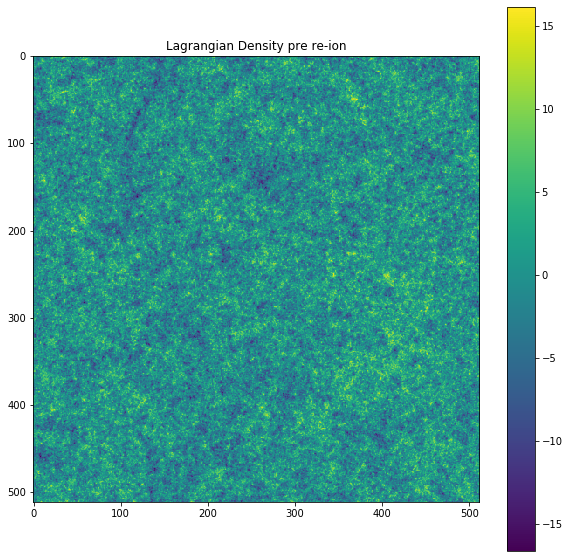

In [2]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'
# datadir = '../multiseed_runs/run0/Boxes/'

freion = open(datadir+'reionization/reion_04')
fdensL  = open(datadir+'density_Lag/dens_04')
fdensE  = open(datadir+'density_Eul/dens_04')

densL = np.fromfile(fdensL, count=N**3, dtype=np.float32).reshape(N,N,N)
densE = np.fromfile(fdensE, count = N**3, dtype=np.float32).reshape(N,N,N)
reion = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


print(densL.shape)
plt.figure(figsize = (10,10))
plt.imshow(densL[0])
plt.colorbar()
plt.title('Lagrangian Density pre re-ion')

In [3]:
#scaling class for use in the vision linear network to image ionization

class ScaleField(): 
    # used min-max scaling HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin
            
density_scalingL = ScaleField(densL)
density_scalingE = ScaleField(densE)
reionization_scaling = ScaleField(reion)

densL = density_scalingL.scale(field=densL)
densE = density_scalingE.scale(field=densE)
reion = reionization_scaling.scale(field=reion)

print(densL.shape)

(512, 512, 512)


In [4]:

def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [5]:
def identity_block(X, filters):
    
    F1, F2, F3 = filters
     
    X_shortcut = X
    
    #first part
    X = tfkl.Conv3D(filters = F1, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
    
    #second part
    X = tfkl.Conv3D(filters = F2, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)

    #third part 
    X = tfkl.Conv3D(filters = F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)

    # add the shortcut identity to the main blocks 
    X = tfkl.Add()([X, X_shortcut])
    X = tfkl.Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters):

    
    F1, F2, F3 = filters
    
    
    X_shortcut = X

    X = tfkl.Conv3D(F1, kernel_size = (5,5,5), strides = (1,1,1),padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
 
    X = tfkl.Conv3D(F2, kernel_size = (f,f,f), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu') (X)

     
    X = tfkl.Conv3D(F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)

    
    X_shortcut = tfkl.Conv3D(F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X_shortcut)
    X_shortcut = tfkl.BatchNormalization()(X_shortcut)

    #add shortcut value to main path
    X = tfkl.Add()([X, X_shortcut])
    X = tfkl.Activation('relu')(X)
    
    
    return X


img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

def Resnet50(input_shape = Input_shape, classes = 3):
    '''
    An attempt at the Resnet50 architecture
   excluding max or average pooling to reduce dimensionality,
   wasn't sure how to restore dimensionality when our
   output requires a (32,32,32) image'''
    
    X_input = tfkl.Input(Input_shape)

    
    
    X = tfkl.BatchNormalization()(X_input)
    
    
    X = tfkl.Conv3D(filters = 18, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    

    
    X = convolutional_block(X, f = 5, filters = [18,18,18])
    X = identity_block(X, [18,18,18])
    X = identity_block(X, [18,18,18])


     
    X = convolutional_block(X, f = 5, filters = [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])

     
    X = convolutional_block(X, f = 5, filters = [30,30,30])
    X = identity_block(X, [30,30,30])
    X = identity_block(X, [30,30,30])
    X = identity_block(X, [30,30,30])
    X = identity_block(X, [30,30,30])
    X = identity_block(X, [30,30,30])

     
    X = convolutional_block(X, f = 3, filters = [36,36,36])
    X = identity_block(X, [36,36,36])
    X = identity_block(X, [36,36,36])


    # output layer
    X = tfkl.Conv3D(filters=1,
                      kernel_size=(1,1,1),
                      strides=(1,1,1),
                      padding= 'same')(X)
    
    model = tfk.models.Model(inputs = X_input, outputs = X)
    
    optimizer = tfk.optimizers.Adam(1e-2)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'])

    return model


(4096, 32, 32, 32, 1)


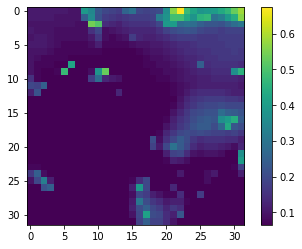

In [6]:
#training data

densL_train = cubify(densL,(img_shape,img_shape,img_shape))[..., np.newaxis]

reion_train = cubify(reion,(img_shape,img_shape,img_shape))[..., np.newaxis]

densE_train = cubify(densE,(img_shape,img_shape,img_shape))[..., np.newaxis]

print(reion_train.shape)

plt.figure()
plt.imshow(reion_train[0,0,...,0])
plt.colorbar()

In [7]:
model = Resnet50() 

model.summary()
print(len(model.layers))

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32, 1 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 32, 1 2268        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32, 1 72          conv3d[0][0]                     
___________________________________________________________________________________________

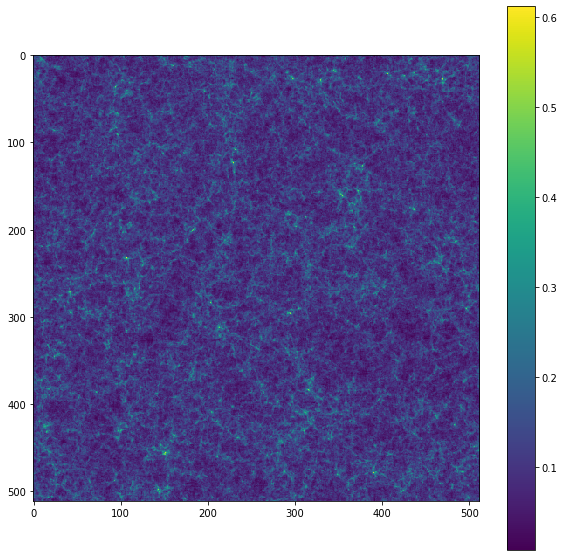

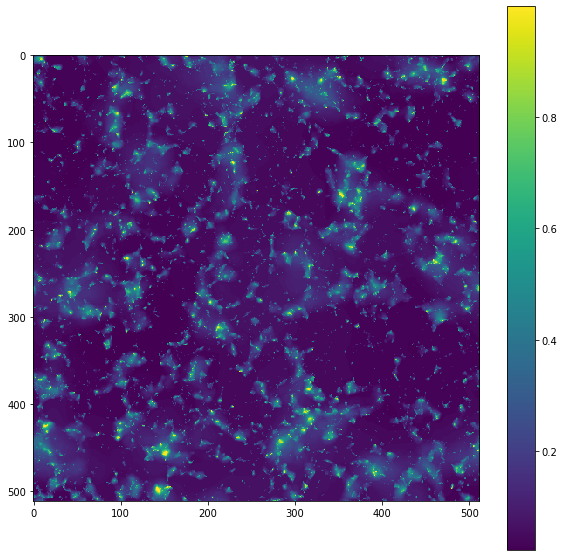

In [8]:
# get test data

freion = open(datadir+'reionization/reion_05')
fdens  = open(datadir+'density_Eul/dens_05')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


x_test = density_scalingE.scale(field=x_test)
y_test = reionization_scaling.scale(field=y_test)


plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]

reion_test  = reionization_scaling.scale(field=y_test,inv=True)

In [9]:
history = model.fit(densE_train,reion_train,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/20
116/116 [==============================] - 346s 3s/step - loss: 2.6076 - mae: 0.2740 - val_loss: 364099.7500 - val_mae: 318.7121
Epoch 2/20
116/116 [==============================] - 342s 3s/step - loss: 0.0157 - mae: 0.0795 - val_loss: 0.0522 - val_mae: 0.1380
Epoch 3/20
116/116 [==============================] - 342s 3s/step - loss: 0.0116 - mae: 0.0666 - val_loss: 0.0232 - val_mae: 0.1201
Epoch 4/20
116/116 [==============================] - 342s 3s/step - loss: 0.0102 - mae: 0.0617 - val_loss: 0.0192 - val_mae: 0.0899
Epoch 5/20
116/116 [==============================] - 342s 3s/step - loss: 0.0093 - mae: 0.0586 - val_loss: 0.0113 - val_mae: 0.0625
Epoch 6/20
116/116 [==============================] - 342s 3s/step - loss: 0.0084 - mae: 0.0559 - val_loss: 0.0128 - val_mae: 0.0564
Epoch 7/20
116/116 [==============================] - 342s 3s/step - loss: 0.0079 - mae: 0.0537 - val_loss: 0.0258 - val_mae: 0.0605
Epoch 8/20
116/116 [==============================] - 342s 3s/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


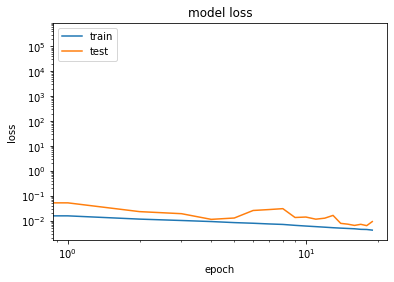

In [10]:

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Resnet_50_trainplot')
plt.show()

In [15]:
model.save('Resnet50')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5_stage_resnet/assets


In [11]:
y_test_predict = model.predict(x_test)

reion_test_predict = reionization_scaling.scale(field = y_test_predict, inv=True)

In [12]:
yshow_predict = reion_test_predict[0,img_shape//2, ..., 0]
yshow = reion_test[0,img_shape//2, ..., 0]
xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

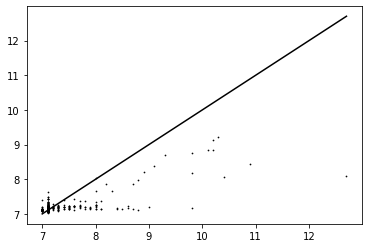

In [13]:
plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)
xx = np.linspace(yshow.min(), yshow.max(), 100)
plt.plot(xx,xx, 'k')

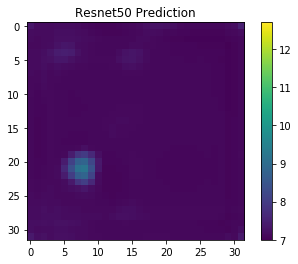

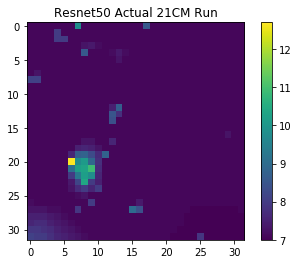

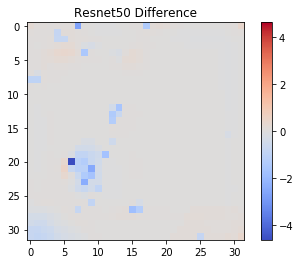

In [16]:
plt.figure()
plt.imshow(yshow_predict, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('Resnet50 Prediction')
plt.savefig('Resnet_50_predict')

plt.figure()
plt.imshow(yshow, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('Resnet50 Actual 21CM Run')
plt.savefig('Resnet_50_actual')

diff = yshow_predict-yshow
plt.figure()
plt.imshow(diff, vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), cmap=plt.get_cmap('coolwarm'))
plt.colorbar()
plt.title('Resnet50 Difference')
plt.savefig('Resnet_50_diff')
